In [2]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
#from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm
from statsmodels.compat import lzip
#sns.set()
#pd.set_option('display.notebook_repr_html', True)
#pd.set_option('display.precision', 2)
#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 10, 10
from scipy.stats import norm
from scipy import stats

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
import sys
sys.path.append('/global/u1/z/zzhang13')

from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

nBootstrap=20

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# function to check VIF
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif

## Collecting the data

For all redshifts and masses

In [19]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as f:
    matched_halo_df = pickle.load(f)

In [20]:
matched_halo_df['lnl'] = np.log10(matched_halo_df['Ngal_R200c'])

In [21]:
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma', 'lnl'],
      dtype='object')

In [22]:
matched_halo_df.Xoff /= 1000

In [23]:
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]

a_bins = [1, 0.6712, 0.4922]
column_name ='Acc_Rate_2*Tdyn'

In [24]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

## Correlation of parameters

In [25]:
display(matched_halo_df[['mvir','M200b','T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir','Xoff']].corr())

,mvir,M200b,T/|U|,Halfmass_Scale,Acc_Rate_Inst,Acc_Rate_100Myr,Acc_Rate_1*Tdyn,Acc_Rate_2*Tdyn,Acc_Rate_Mpeak,c_vir,Xoff
mvir,1.000000,0.996814,0.034243,0.407490,0.338197,0.338197,0.529013,0.670650,0.691656,-0.019834,0.314235
M200b,0.996814,1.000000,0.015476,0.422950,0.322744,0.322744,0.492807,0.632935,0.656648,-0.012628,0.296177
T/|U|,0.034243,0.015476,1.000000,0.056472,0.443808,0.443808,0.515368,0.377279,0.348402,-0.332531,0.628834
Halfmass_Scale,0.407490,0.422950,0.056472,1.000000,0.043399,0.043399,0.159429,0.161179,0.125184,-0.017502,0.254800
Acc_Rate_Inst,0.338197,0.322744,0.443808,0.043399,1.000000,1.000000,0.717195,0.571530,0.557310,-0.262031,0.482098
Acc_Rate_100Myr,0.338197,0.322744,0.443808,0.043399,1.000000,1.000000,0.717195,0.571530,0.557310,-0.262031,0.482098
Acc_Rate_1*Tdyn,0.529013,0.492807,0.515368,0.159429,0.717195,0.717195,1.000000,0.869208,0.822113,-0.172100,0.561522
Acc_Rate_2*Tdyn,0.670650,0.632935,0.377279,0.161179,0.571530,0.571530,0.869208,1.000000,0.966471,-0.291226,0.561393
Acc_Rate_Mpeak,0.691656,0.656648,0.348402,0.125184,0.557310,0.557310,0.822113,0.966471,1.000000,-0.278141,0.533612
c_vir,-0.019834,-0.012628,-0.332531,-0.017502,-0.262031,-0.262031,-0.172100,-0.291226,-0.278141,1.000000,-0.502686


## Summary statistics of multi-linear regression

In [26]:
from scipy import stats
nBootstrap = 10
X_params = ['T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff']

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
        print('M{:.2g}-{:.2g}, z={:.2f}'.format(mass_min, mass_max, 1/cur_a_bin-1))
        
        mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
        cur_df = matched_halo_df[mask]
            

        ##Apply linear regression
        X = cur_df[X_params]
        X = sm.add_constant(X)
        y = np.log10(np.array(cur_df['Ngal_R200c'],dtype=float))
        mreg = sm.OLS(y, X).fit()
        
        display(mreg.summary())
        
        print(X.columns)
        (F, pval) = f_regression(X, y)
        display(F, pval)

M5e+13-1e+14, z=0.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     78.35
Date:                Tue, 30 May 2023   Prob (F-statistic):           2.03e-60
Time:                        08:02:48   Log-Likelihood:                 298.11
No. Observations:                 500   AIC:                            -584.2
Df Residuals:                     494   BIC:                            -558.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7161      0.093      7.732      0.000       0.534       0.898
T/|U|               1.2960      0.157      8.269      0.000       0.988       1.604
c_vir              -0.0315      0.004     -7.183      0.000      -0.040      -0.023
Halfmass_Scale     -0.1027      0.084     -1.230      0.219      -0.267       0.061
Acc_Rate_2*Tdyn  1.442e-05   1.95e-06      7.399      0.000    1.06e-05    1.82e-05
Xoff               -1.6177      0.233     -6.946      0.000      -2.075      -1.160
==============================================================================
Omnibus:                       13.565   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.008
Skew:                          -0.375   Prob(JB):                     0.000908
Kurtosis:                       3.330   Cond. No.                     3.69e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([         nan, 165.26628809, 151.44804286, 150.48186603,
       240.72674039,  77.52612777])

array([           nan, 7.27936150e-33, 1.42227824e-30, 2.06552642e-30,
       1.42050761e-44, 2.17227425e-17])

M5e+13-1e+14, z=0.49


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     51.01
Date:                Tue, 30 May 2023   Prob (F-statistic):           1.30e-42
Time:                        08:02:48   Log-Likelihood:                 240.74
No. Observations:                 500   AIC:                            -469.5
Df Residuals:                     494   BIC:                            -444.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6635      0.095      6.955      0.000       0.476       0.851
T/|U|               0.2802      0.132      2.126      0.034       0.021       0.539
c_vir               0.0144      0.005      2.792      0.005       0.004       0.025
Halfmass_Scale      0.1883      0.161      1.166      0.244      -0.129       0.506
Acc_Rate_2*Tdyn  1.678e-05   1.73e-06      9.699      0.000    1.34e-05    2.02e-05
Xoff               -0.3002      0.189     -1.590      0.113      -0.671       0.071
==============================================================================
Omnibus:                       26.068   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.277
Skew:                          -0.413   Prob(JB):                     4.88e-09
Kurtosis:                       4.075   Cond. No.                     4.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([         nan,  74.74221161,  22.3998541 , 120.74466571,
       229.22434596,  44.71312134])

array([           nan, 7.37844075e-17, 2.88916330e-06, 2.68020670e-25,
       7.18813889e-43, 6.13878815e-11])

M5e+13-1e+14, z=1.03


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     56.36
Date:                Tue, 30 May 2023   Prob (F-statistic):           2.48e-46
Time:                        08:02:48   Log-Likelihood:                 246.89
No. Observations:                 500   AIC:                            -481.8
Df Residuals:                     494   BIC:                            -456.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2948      0.107      2.767      0.006       0.085       0.504
T/|U|               0.3533      0.136      2.601      0.010       0.086       0.620
c_vir               0.0240      0.005      4.493      0.000       0.014       0.034
Halfmass_Scale      0.5692      0.269      2.119      0.035       0.041       1.097
Acc_Rate_2*Tdyn  1.235e-05    1.2e-06     10.296      0.000    9.99e-06    1.47e-05
Xoff               -0.8110      0.184     -4.412      0.000      -1.172      -0.450
==============================================================================
Omnibus:                       26.704   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.551
Skew:                          -0.564   Prob(JB):                     3.83e-07
Kurtosis:                       3.381   Cond. No.                     9.62e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([         nan,  16.83967529,   5.2370569 , 104.32571004,
       181.47563113,   0.85932669])

array([           nan, 4.75179018e-05, 2.25286479e-02, 2.30071480e-22,
       1.72282876e-35, 3.54376215e-01])

M1e+14-2e+14, z=0.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     76.71
Date:                Tue, 30 May 2023   Prob (F-statistic):           1.98e-59
Time:                        08:02:48   Log-Likelihood:                 399.70
No. Observations:                 500   AIC:                            -787.4
Df Residuals:                     494   BIC:                            -762.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2461      0.083     14.965      0.000       1.083       1.410
T/|U|               0.8346      0.154      5.423      0.000       0.532       1.137
c_vir              -0.0209      0.004     -5.415      0.000      -0.028      -0.013
Halfmass_Scale     -0.1978      0.071     -2.803      0.005      -0.336      -0.059
Acc_Rate_2*Tdyn  8.761e-06   8.04e-07     10.903      0.000    7.18e-06    1.03e-05
Xoff               -0.7656      0.152     -5.034      0.000      -1.064      -0.467
==============================================================================
Omnibus:                        5.264   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.361
Skew:                          -0.249   Prob(JB):                       0.0685
Kurtosis:                       2.902   Cond. No.                     6.91e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([         nan, 125.37803629, 108.7845286 , 114.69874472,
       312.58939359,  63.85919124])

array([           nan, 4.12070712e-26, 3.60551797e-23, 3.15401824e-24,
       1.19488413e-54, 9.36789367e-15])

M1e+14-2e+14, z=0.49


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     51.24
Date:                Tue, 30 May 2023   Prob (F-statistic):           9.00e-43
Time:                        08:02:48   Log-Likelihood:                 324.29
No. Observations:                 500   AIC:                            -636.6
Df Residuals:                     494   BIC:                            -611.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.3113      0.087     15.111      0.000       1.141       1.482
T/|U|               0.2259      0.143      1.584      0.114      -0.054       0.506
c_vir           -8.735e-05      0.005     -0.018      0.986      -0.010       0.010
Halfmass_Scale     -0.3531      0.158     -2.241      0.025      -0.663      -0.044
Acc_Rate_2*Tdyn  8.793e-06   7.46e-07     11.793      0.000    7.33e-06    1.03e-05
Xoff               -0.3652      0.135     -2.705      0.007      -0.630      -0.100
==============================================================================
Omnibus:                      223.036   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2011.792
Skew:                          -1.708   Prob(JB):                         0.00
Kurtosis:                      12.214   Cond. No.                     9.83e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([         nan,  45.64113288,  22.76624283,  86.02447603,
       234.3174749 ,  21.64921611])

array([           nan, 3.97572355e-11, 2.40741687e-06, 5.40624982e-19,
       1.25511689e-43, 4.20146886e-06])

M1e+14-2e+14, z=1.03


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     58.24
Date:                Tue, 30 May 2023   Prob (F-statistic):           1.31e-47
Time:                        08:02:48   Log-Likelihood:                 341.18
No. Observations:                 500   AIC:                            -670.4
Df Residuals:                     494   BIC:                            -645.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8580      0.092      9.355      0.000       0.678       1.038
T/|U|               0.2923      0.139      2.106      0.036       0.020       0.565
c_vir               0.0246      0.004      5.645      0.000       0.016       0.033
Halfmass_Scale     -0.2333      0.234     -0.996      0.320      -0.693       0.227
Acc_Rate_2*Tdyn  6.558e-06   4.91e-07     13.346      0.000    5.59e-06    7.52e-06
Xoff               -0.3482      0.123     -2.835      0.005      -0.590      -0.107
==============================================================================
Omnibus:                       90.661   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.130
Skew:                          -0.865   Prob(JB):                     1.98e-57
Kurtosis:                       6.089   Cond. No.                     2.14e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([         nan,  25.19061139,   5.13442396,  63.93154905,
       196.33885635,   7.61289518])

array([           nan, 7.24199239e-07, 2.38842989e-02, 9.06787554e-15,
       7.65639577e-38, 6.00860421e-03])

M2e+14-5e+14, z=0.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     113.4
Date:                Tue, 30 May 2023   Prob (F-statistic):           1.16e-79
Time:                        08:02:48   Log-Likelihood:                 402.49
No. Observations:                 500   AIC:                            -793.0
Df Residuals:                     494   BIC:                            -767.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.7005      0.071     23.894      0.000       1.561       1.840
T/|U|               0.5586      0.129      4.339      0.000       0.306       0.812
c_vir              -0.0157      0.004     -3.987      0.000      -0.023      -0.008
Halfmass_Scale     -0.2919      0.069     -4.225      0.000      -0.428      -0.156
Acc_Rate_2*Tdyn  5.838e-06   3.33e-07     17.555      0.000    5.18e-06    6.49e-06
Xoff               -0.5736      0.109     -5.285      0.000      -0.787      -0.360
==============================================================================
Omnibus:                        1.322   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.516   Jarque-Bera (JB):                1.143
Skew:                          -0.105   Prob(JB):                        0.565
Kurtosis:                       3.102   Cond. No.                     1.30e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([         nan,  79.96838881,  90.34787413, 106.5380153 ,
       487.17601804,  62.25122887])

array([           nan, 7.47030455e-18, 8.44298361e-20, 9.15636574e-23,
       8.51726703e-76, 1.93338376e-14])

M2e+14-5e+14, z=0.49


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     41.02
Date:                Tue, 30 May 2023   Prob (F-statistic):           2.65e-35
Time:                        08:02:48   Log-Likelihood:                 277.71
No. Observations:                 500   AIC:                            -543.4
Df Residuals:                     494   BIC:                            -518.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.5146      0.085     17.839      0.000       1.348       1.681
T/|U|               0.2773      0.119      2.340      0.020       0.044       0.510
c_vir               0.0161      0.005      3.405      0.001       0.007       0.025
Halfmass_Scale     -0.3885      0.168     -2.318      0.021      -0.718      -0.059
Acc_Rate_2*Tdyn   4.15e-06   3.54e-07     11.714      0.000    3.45e-06    4.85e-06
Xoff               -0.2705      0.112     -2.426      0.016      -0.490      -0.051
==============================================================================
Omnibus:                      473.151   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20182.570
Skew:                          -4.033   Prob(JB):                         0.00
Kurtosis:                      33.062   Cond. No.                     1.87e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([           nan, 2.11601584e+01, 4.69261629e-02, 4.50612236e+01,
       1.54275205e+02, 9.74333720e+00])

array([           nan, 5.36535888e-06, 8.28589721e-01, 5.21513961e-11,
       4.78888438e-31, 1.90428663e-03])

M2e+14-5e+14, z=1.03


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     46.62
Date:                Tue, 30 May 2023   Prob (F-statistic):           4.72e-35
Time:                        08:02:48   Log-Likelihood:                 253.31
No. Observations:                 289   AIC:                            -494.6
Df Residuals:                     283   BIC:                            -472.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2263      0.111     11.057      0.000       1.008       1.445
T/|U|               0.3329      0.188      1.768      0.078      -0.038       0.703
c_vir               0.0081      0.005      1.647      0.101      -0.002       0.018
Halfmass_Scale     -0.1571      0.266     -0.590      0.555      -0.681       0.367
Acc_Rate_2*Tdyn  2.644e-06   2.17e-07     12.195      0.000    2.22e-06    3.07e-06
Xoff               -0.5491      0.109     -5.016      0.000      -0.765      -0.334
==============================================================================
Omnibus:                        6.427   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                6.186
Skew:                          -0.323   Prob(JB):                       0.0454
Kurtosis:                       3.312   Cond. No.                     5.00e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  5e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([         nan,   4.39308083,   9.34873888,  23.34355497,
       137.53314339,   2.67730371])

array([           nan, 3.69607674e-02, 2.44175472e-03, 2.20921176e-06,
       3.27362316e-26, 1.02884040e-01])

M5e+14-1e+15, z=0.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     82.39
Date:                Tue, 30 May 2023   Prob (F-statistic):           8.06e-63
Time:                        08:02:48   Log-Likelihood:                 565.29
No. Observations:                 500   AIC:                            -1119.
Df Residuals:                     494   BIC:                            -1093.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.1902      0.052     42.405      0.000       2.089       2.292
T/|U|               0.2317      0.093      2.496      0.013       0.049       0.414
c_vir              -0.0091      0.003     -3.296      0.001      -0.014      -0.004
Halfmass_Scale     -0.1480      0.054     -2.753      0.006      -0.254      -0.042
Acc_Rate_2*Tdyn  1.826e-06   1.32e-07     13.793      0.000    1.57e-06    2.09e-06
Xoff               -0.2464      0.057     -4.301      0.000      -0.359      -0.134
==============================================================================
Omnibus:                        0.434   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.547
Skew:                           0.029   Prob(JB):                        0.761
Kurtosis:                       2.848   Cond. No.                     2.88e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([         nan,  62.73366918,  65.81266164, 117.18601792,
       365.99487714,  51.2555755 ])

array([           nan, 1.55524202e-14, 3.89684738e-15, 1.14039486e-24,
       1.43640576e-61, 2.92631385e-12])

M5e+14-1e+15, z=0.49


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     10.50
Date:                Tue, 30 May 2023   Prob (F-statistic):           1.75e-08
Time:                        08:02:48   Log-Likelihood:                 106.44
No. Observations:                 136   AIC:                            -200.9
Df Residuals:                     130   BIC:                            -183.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.2635      0.197     11.511      0.000       1.874       2.652
T/|U|              -0.0419      0.306     -0.137      0.891      -0.648       0.564
c_vir              -0.0028      0.009     -0.313      0.754      -0.020       0.015
Halfmass_Scale     -0.5378      0.331     -1.624      0.107      -1.193       0.117
Acc_Rate_2*Tdyn   1.94e-06   3.16e-07      6.148      0.000    1.32e-06    2.56e-06
Xoff               -0.4078      0.143     -2.845      0.005      -0.691      -0.124
==============================================================================
Omnibus:                      159.655   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5694.895
Skew:                          -4.187   Prob(JB):                         0.00
Kurtosis:                      33.575   Cond. No.                     6.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([        nan,  0.07997793,  0.34830645,  4.09476069, 25.63319371,
        1.25306241])

array([           nan, 7.77763705e-01, 5.56067317e-01, 4.50048218e-02,
       1.33707429e-06, 2.64970886e-01])

M5e+14-1e+15, z=1.03


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 30 May 2023   Prob (F-statistic):                nan
Time:                        08:02:48   Log-Likelihood:                 115.57
No. Observations:                   5   AIC:                            -221.1
Df Residuals:                       0   BIC:                            -223.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.5311        inf          0        nan         nan         nan
T/|U|               0.9184        inf          0        nan         nan         nan
c_vir              -0.1248        inf         -0        nan         nan         nan
Halfmass_Scale      1.8189        inf          0        nan         nan         nan
Acc_Rate_2*Tdyn  1.535e-06        inf          0        nan         nan         nan
Xoff               -3.7076        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.802
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.407
Skew:                          -0.170   Prob(JB):                        0.816
Kurtosis:                       1.644   Cond. No.                     1.93e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
[3] The condition number is large, 1.93e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['const', 'T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([       nan, 1.52376295, 2.68300471, 1.0031954 , 1.20041498,
       2.15929048])

array([       nan, 0.30492752, 0.19995008, 0.39034263, 0.35331644,
       0.23804569])

## Testing the model on subset of data
Using z=0.00, one single mass bin

* Determine using F-regression which variables to use.
* Check for residuals
* Homodescedity
* Normal errors
* Multi-collinearity

In [25]:
a_bins = [1, 0.6712, 0.4922]

In [37]:
mask = (matched_halo_df.mvir >= 1e14) & (matched_halo_df.mvir < 2e14) & (matched_halo_df.scale == 1) 
cur_df = matched_halo_df[mask]

In [38]:
cur_df.c_vir

14      4.132651
15      5.114444
16      7.612013
17      3.514530
18      7.178709
          ...   
1200    2.934424
1201    5.090178
1202    2.309766
1203    4.432682
1204    8.732649
Name: c_vir, Length: 507, dtype: float64

In [39]:
Mvir = np.log10(np.copy(cur_df['mvir']))
richness = np.copy(cur_df['Ngal_R200c'])

In [40]:
cur_df['logM'] = np.log10(Mvir)
cur_df['lnl'] = np.log10(richness)

##Inclusive of all parameters
X_params = ['T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff']
#X_params = ['Halfmass_Scale', 'Acc_Rate_2*Tdyn']
X = cur_df[X_params]
#X = cur_df[['logM', 'Acc_Rate_2*Tdyn']]

#DS_inner = np.copy(cur_df['delta_sigma'])
#DS_inner = np.vstack(DS_inner)
#DS_inner = DS_inner[:,0]
y = np.log10(richness)


In [41]:
X = sm.add_constant(X)
mreg = sm.OLS(y, X).fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     62.34
Date:                Thu, 26 Jan 2023   Prob (F-statistic):           1.69e-50
Time:                        11:42:59   Log-Likelihood:                 361.87
No. Observations:                 507   AIC:                            -711.7
Df Residuals:                     501   BIC:                            -686.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1266      0.087     12.984      0.000       0.956       1.297
T/|U|               0.6815      0.149      4.568      0.000       0.388       0.975
c_vir              -0.0132      0.004     -3.274      0.001      -0.021      -0.005
Halfmass_Scale     -0.0129      0.079     -0.163      0.870      -0.168       0.142
Acc_Rate_2*Tdyn  9.692e-06   9.97e-07      9.717      0.000    7.73e-06    1.17e-05
Xoff               -0.0009      0.000     -5.012      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       10.960   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.129
Skew:                          -0.360   Prob(JB):                      0.00383
Kurtosis:                       3.096   Cond. No.                     4.55e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Apply a F-regression test to see which variables to use and which to omit

Highest one is 'Acc_Rate_2*Tdyn' and 'logM'

In [331]:
print(X.columns)
(F, pval) = f_regression(X, y)
display(F, pval)

Index(['const', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn'], dtype='object')


array([         nan,  62.3922991 , 316.15032861])

array([           nan, 1.81413641e-14, 3.99774914e-55])

### Test for homodescitiy

If p>0.05 keep the null hypothesis for homodescity

In [332]:
## Test for homodes
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(mreg.resid, mreg.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 11.012898934992855),
 ('p-value', 0.004060498752392812),
 ('f-value', 5.596682160705698),
 ('f p-value', 0.003947831294861755)]

### Check for multi-collinearity

VIF > 5 include:
* Acc_Rate parameters. Retain only 1

In [333]:
print(checking_vif(X))

           feature        VIF
0            const  92.263964
1   Halfmass_Scale   2.017006
2  Acc_Rate_2*Tdyn   2.017006


### Check for Gaussian residuals 

In [334]:
residuals = mreg.resid

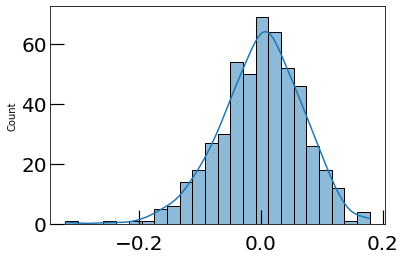

In [335]:
# Plot histogram of residuals
sns.histplot(residuals, kde=True)
plt.show()

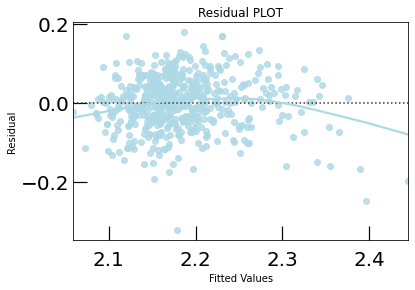

In [336]:
fitted = mreg.fittedvalues

# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residuals, color="lightblue", lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

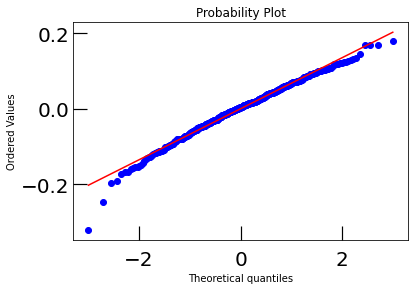

In [337]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

In [338]:
## Apply the KS Test
from scipy.stats import kstest, norm
ks_statistic, p_value = kstest(residuals, 'norm')
print(ks_statistic, p_value)

0.43637764852644245 3.9485338999690644e-87


In [339]:
## Apply the Shapiro-Wilk test
from scipy.stats import norm
from scipy import stats
stats.shapiro(residuals)

ShapiroResult(statistic=0.9874087572097778, pvalue=0.0002602220047265291)

### Mean of residuals =0 

In [340]:
print(np.mean(residuals))
print(np.std(residuals))

2.2447284919735467e-11
0.06785534984154334


### Reduce coefficients using M and highest F-statistic only


In [248]:
X_reduce = cur_df[['Acc_Rate_2*Tdyn']]

In [249]:
X_reduce = sm.add_constant(X_reduce)
mreg2 = sm.OLS(y, X_reduce).fit()
display(mreg2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     160.2
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           5.18e-30
Time:                        17:56:42   Log-Likelihood:                 295.02
No. Observations:                 320   AIC:                            -586.0
Df Residuals:                     318   BIC:                            -578.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.5449      0.014    106.950      0.000       1.516       1.573
Acc_Rate_2*Tdyn  8.892e-06   7.03e-07     12.657      0.000    7.51e-06    1.03e-05
==============================================================================
Omnibus:                        0.857   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.652   Jarque-Bera (JB):                0.750
Skew:                          -0.118   Prob(JB):                        0.687
Kurtosis:                       3.028   Cond. No.                     5.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [250]:
print(checking_vif(X_reduce))

           feature       VIF
0            const  7.163278
1  Acc_Rate_2*Tdyn  1.000000


### Check for Gaussian residuals

In [251]:
residuals = mreg2.resid

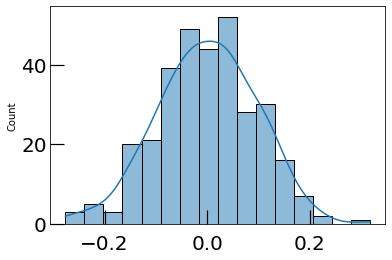

In [252]:
# Plot histogram of residuals
sns.histplot(residuals, kde=True)
plt.show()

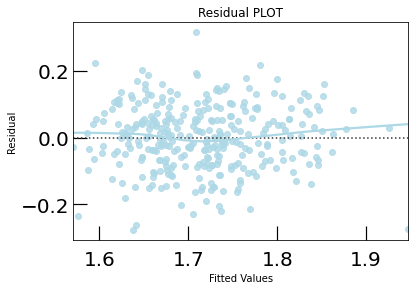

In [253]:
fitted = mreg2.fittedvalues

# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residuals, color="lightblue", lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

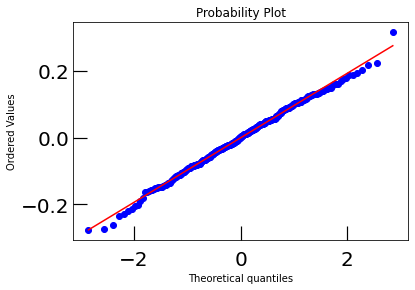

In [254]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

In [255]:
## Apply the KS Test
from scipy.stats import kstest, norm
ks_statistic, p_value = kstest(residuals, 'norm')
print(ks_statistic, p_value)

0.41059276515894283 2.6218726615983446e-49


## Compute Covariance

Run across mass and redshift bins for the full linear regression model. 

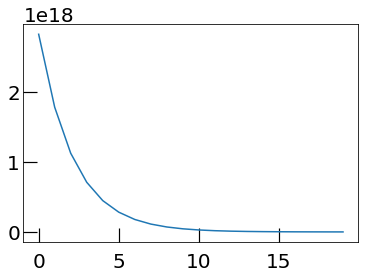

In [347]:
plt.plot(np.mean(np.vstack(cur_df.delta_sigma), axis=0))
plt.show()

In [348]:
display(cur_df[['mvir','M200b','T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir']].corr())



,mvir,T/|U|,Halfmass_Scale,Acc_Rate_Inst,Acc_Rate_100Myr,Acc_Rate_1*Tdyn,Acc_Rate_2*Tdyn,Acc_Rate_Mpeak,c_vir
mvir,1.000000,0.053001,0.047163,0.253403,0.253403,0.372796,0.577193,0.615652,-0.048180
T/|U|,0.053001,1.000000,0.638348,0.596490,0.596490,0.722642,0.459072,0.422157,-0.156246
Halfmass_Scale,0.047163,0.638348,1.000000,0.387201,0.387201,0.691031,0.710081,0.692476,-0.321483
Acc_Rate_Inst,0.253403,0.596490,0.387201,1.000000,1.000000,0.647544,0.407901,0.376055,-0.314551
Acc_Rate_100Myr,0.253403,0.596490,0.387201,1.000000,1.000000,0.647544,0.407901,0.376055,-0.314551
Acc_Rate_1*Tdyn,0.372796,0.722642,0.691031,0.647544,0.647544,1.000000,0.743551,0.678532,-0.144025
Acc_Rate_2*Tdyn,0.577193,0.459072,0.710081,0.407901,0.407901,0.743551,1.000000,0.977836,-0.345438
Acc_Rate_Mpeak,0.615652,0.422157,0.692476,0.376055,0.376055,0.678532,0.977836,1.000000,-0.348283
c_vir,-0.048180,-0.156246,-0.321483,-0.314551,-0.314551,-0.144025,-0.345438,-0.348283,1.000000


In [349]:
nBootstrap = 10
xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['mvir'],dtype=float)) , np.vstack(cur_df['delta_sigma']), \
                                       np.log10(np.array(cur_df['Ngal'],dtype=float)), nBootstrap=nBootstrap)
cov_ds_ngal_kllr = output['covariance']
cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

xline, output = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.log10(np.array(cur_df['Ngal'],dtype=float)), nBootstrap=nBootstrap)

cov_ds_ngal_simple = output['covariance']
cov_mean_simple = np.mean(cov_ds_ngal_simple, axis=0)
cov_err_simple = np.std(cov_ds_ngal_simple, axis=0)

100%|██████████| 10/10 [00:00<00:00, 562.30it/s]


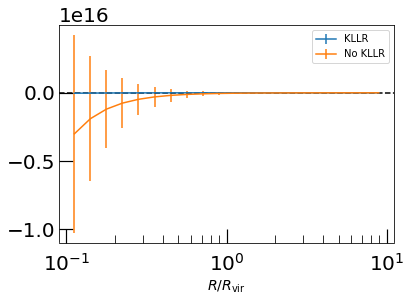

In [350]:
plt.errorbar(r_cent_lin_norm, cov_mean_kllr, yerr = cov_err_kllr, label = 'KLLR')
plt.errorbar(r_cent_lin_norm, cov_mean_simple, yerr = cov_err_simple, label='No KLLR')
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log'); #plt.yscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

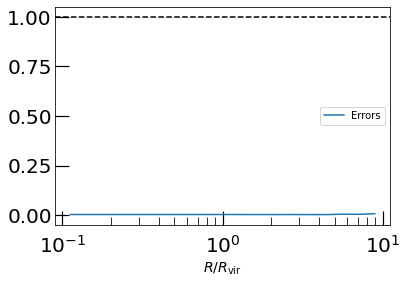

In [351]:
plt.plot(r_cent_lin_norm, cov_err_kllr/cov_err_simple, label='Errors')
plt.axhline(1,linestyle='dashed', color='black')
plt.xscale('log'); #plt.yscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

### Bin by mass

In [352]:
nBootstrap = 10

## Need to build the covariance of the other time formation parameter terms
coeff_halfmass_scale = mreg.params['Halfmass_Scale']	
coeff_T_U = mreg.params['T/|U|']
coeff_c_vir = mreg.params['c_vir']
coeff_Acc_Rate_2Tdyn = mreg.params['Acc_Rate_2*Tdyn']

xline, cov_corr_halfmass_scale = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df['Halfmass_Scale'],dtype=float), nBootstrap=nBootstrap)
xline, cov_corr_T_U = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df['T/|U|'],dtype=float), nBootstrap=nBootstrap)
xline, cov_corr_c_vir = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df['c_vir'],dtype=float), nBootstrap=nBootstrap)
xline, cov_corr_Acc_Rate_Mpeak = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df['Acc_Rate_2*Tdyn'],dtype=float), nBootstrap=nBootstrap)


KeyError: 'T/|U|'

In [265]:
cov_halfmass_scale = np.mean(cov_corr_halfmass_scale['covariance'], axis=0)
cov_T_U = np.mean(cov_corr_T_U['covariance'], axis=0)
cov_c_vir = np.mean(cov_corr_c_vir['covariance'], axis=0)
cov_Acc_Rate_2Tdyn = np.mean(cov_corr_Acc_Rate_Mpeak['covariance'], axis=0)

['T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn']
T/|U|


100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


c_vir


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Halfmass_Scale


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Acc_Rate_2*Tdyn


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


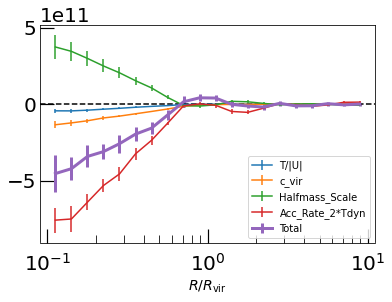

In [272]:
### Iterate through X
print(X_params)
for X_param in iter(X_params):
    print(X_param)
    coeff_param = mreg.params[X_param]
    #xline, cov_corr = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df[X_param],dtype=float), nBootstrap=nBootstrap)
    xline, cov_corr = calc_cov_KLLR(np.log10(np.array(cur_df['mvir'],dtype=float)), np.vstack(cur_df['delta_sigma']), \
                                    np.array(cur_df[X_param],dtype=float), nBootstrap=nBootstrap)
    
    cov_param = np.mean(cov_corr['covariance'], axis=0)
    cov_err_param = np.std(cov_corr['covariance'], axis=0)
    plt.errorbar(r_cent_lin_norm, coeff_param*cov_param, yerr=coeff_param*cov_err_param, label=X_param)

plt.errorbar(r_cent_lin_norm, cov_mean_kllr, yerr = cov_err_kllr, linewidth=3, label='Total')
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log'); #plt.yscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


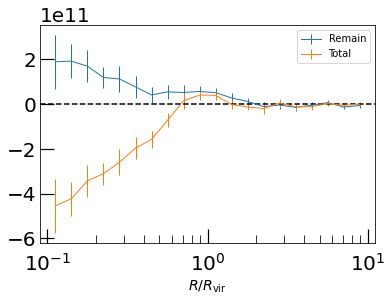

In [267]:
### Iterate through X
cov_remain_kllr = np.copy(cov_mean_kllr)
for X_param in iter(X_params):
    coeff_param = mreg.params[X_param]
    #xline, cov_corr = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df[X_param],dtype=float), nBootstrap=nBootstrap)
    xline, cov_corr = calc_cov_KLLR(np.log10(np.array(cur_df['mvir'],dtype=float)), np.vstack(cur_df['delta_sigma']), \
                                    np.array(cur_df[X_param],dtype=float), nBootstrap=nBootstrap)
    
    cov_param = np.mean(cov_corr['covariance'], axis=0)
    cov_remain_kllr -= coeff_param*cov_param

plt.errorbar(r_cent_lin_norm, cov_remain_kllr, yerr = cov_err_kllr, linewidth=1, label='Remain')
plt.errorbar(r_cent_lin_norm, cov_mean_kllr, yerr = cov_err_kllr, linewidth=1, label='Total')
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log'); 
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

In [268]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

In [269]:
cov_remain = cov_mean - coeff_Acc_Rate_2Tdyn*cov_Acc_Rate_2Tdyn

In [270]:
cov_remain

array([-3.93733882e+11, -3.10377161e+11, -2.33009160e+11, -1.93278683e+11,
       -1.58438856e+11, -1.00113072e+11, -7.13595819e+10, -4.18902434e+10,
       -5.49843156e+09,  1.35013318e+10,  1.22211164e+10,  1.13165410e+10,
       -1.79839747e+10, -2.30563452e+10, -1.10197785e+10, -8.35956722e+09,
        1.19137692e+10,  1.59026042e+10,  1.17122714e+10,  2.29120690e+09])

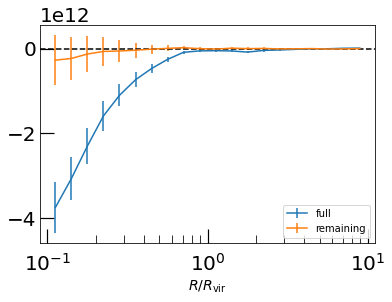

In [311]:
plt.errorbar(r_cent_lin_norm, cov_mean, yerr = cov_err, label = 'full')
plt.errorbar(r_cent_lin_norm, cov_remain, yerr = cov_err, label='remaining')
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log'); #plt.yscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()